# Histopathologic Cancer Detection

In [39]:
# If you want to connect your google drive, you can execute this block
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
# load libraries
import os, time, json, re, copy
import itertools, collections
import argparse, pickle, random

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import models

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold

import io
import requests
import PIL
from PIL import Image
import cv2

from tqdm import tqdm, tqdm_notebook
from collections import namedtuple
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
device = torch.device('cuda')
dtype = torch.cuda.FloatTensor

SEED = 2019
path = '/content/'
model_path = '/content/drive/My Drive/DL_projects/cv_cancer_detection/'

n_splits = 5
batch_size = 128
img_size = 196

In [37]:
!ls

drive  sample_data  train  train_labels.csv


## Download data

In [0]:
!mkdir /root/.kaggle
!cp /content/drive/My\ Drive/DL_projects/Data/kaggle.json /root/.kaggle/

In [0]:
!kaggle competitions download -c histopathologic-cancer-detection -f train.zip

100% 4.97G/4.98G [02:12<00:00, 35.3MB/s]
100% 4.98G/4.98G [02:12<00:00, 40.3MB/s]


In [0]:
!mkdir train
!mv train.zip train/

In [0]:
!unzip -q train/train.zip

In [0]:
!rm train/train.zip

In [33]:
!kaggle competitions download -c histopathologic-cancer-detection -f train_labels.csv

 98% 5.00M/5.10M [00:00<00:00, 32.1MB/s]
100% 5.10M/5.10M [00:00<00:00, 32.6MB/s]


In [0]:
!unzip -q train_labels.csv.zip

In [0]:
!rm train_labels.csv.zip

## Load data

In [0]:
rgb_mean = [0.485, 0.456, 0.406]
rgb_std = [0.229, 0.224, 0.225]

tsfm_normal = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
            T.Normalize(rgb_mean, rgb_std),
        ])

class HCDDataset(Dataset):

    def __init__(self, path, indices=None, df=None):
        """
        :param path: path where data files are stored
        :param split: split, one of 'TRAIN', 'VALID', or 'TEST'
        """
        self.path = path
        if df is not None:
            self.files = df['id'][indices].tolist()
            self.targets = df['label'][indices].values[:,None]
        else:
            self.files = os.listdir(path+'test')
            self.targets = None

    def __getitem__(self, index):
        transform = tsfm_normal
        if self.targets is not None:
            image = Image.open(self.path+'train/'+self.files[index]+'.tif', mode='r')
            image = image.convert('RGB')
            return transform(image), torch.FloatTensor(self.targets[index])
        else:
            image = Image.open(self.path+'test/'+self.files[index], mode='r')
            image = image.convert('RGB')
            return transform(image)

    def __len__(self):
        return len(self.files)

In [0]:
def load_meta_data():
    return pd.read_csv(path+'train_labels.csv')

def train_val_split(train_df):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    cv_indices = [(tr_idx, val_idx) for tr_idx, val_idx in kf.split(train_df['id'], train_df['label'])]
    return cv_indices

In [0]:
train_df = load_meta_data()
cv_indices = train_val_split(train_df)
val_idx = cv_indices[0][1]
val_dataset = HCDDataset(path, val_idx, train_df)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## Load model

In [0]:
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`,"
    "a module from fastai v1."
    def __init__(self, output_size=None):
        "Output will be 2*output_size or 2 if output_size is None"
        super().__init__()
        self.output_size = output_size or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

class ImgClassifier(nn.Module):
    def __init__(self, final_fmaps, out_dim):
        super(ImgClassifier, self).__init__()
        self.adapt_pool = AdaptiveConcatPool2d((1,1))
        self.flatten = Flatten()
        self.fc = nn.Linear(final_fmaps*2, out_dim)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0.)

    def forward(self, x):
        x = self.adapt_pool(x)
        x = self.flatten(x)
        return self.fc(x)

class HCDNet(nn.Module):
    def __init__(self, net):
        super(HCDNet, self).__init__()
        net_lyrs = [c for n,c in net.named_children()]
        self.backbone1 = nn.Sequential(*net_lyrs[:5])
        self.backbone2 = nn.Sequential(*net_lyrs[5:-2])
        self.classifier = ImgClassifier(net_lyrs[-1].in_features, 1)

    def forward(self, x):
        x = self.backbone1(x)
        x = self.backbone2(x)
        out = self.classifier(x)
        return out

def load_model():
    net = models.resnet50(pretrained=True)
    model_states = torch.load(model_path+'models.pt')
    model = HCDNet(copy.deepcopy(net))
    model.load_state_dict(model_states[f'fold_0'])
    return model

In [0]:
net = load_model()

## Evaluation

In [0]:
def validate(model, val_loader):
    val_auc, val_loss, val_scores = check_auc(val_loader, model)
    print('{"metric": "Val. Loss", "value": %.4f}' % (val_loss, ))
    print('{"metric": "Val. AUC", "value": %.4f}' % (val_auc, ))
    return val_scores, val_auc

def check_auc(loader, model):
    model.eval()
    targets, scores, losses = [], [], []

    with torch.no_grad():
        for t, (x, y) in enumerate(tqdm_notebook(loader)):
            x = x.to(device)
            y = y.to(device)
            score = model(x)
            l = nn.BCEWithLogitsLoss()(score, y)
            targets.append(y[:,0].cpu().numpy())
            scores.append(torch.sigmoid(score[:,0]).cpu().numpy())
            losses.append(l.item())

    targets = np.concatenate(targets)
    scores = np.concatenate(scores)
    auc = roc_auc_score(targets, scores)
    loss = np.mean(losses)

    return auc, loss, scores

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.astype('float') / cm.sum().astype(np.float32)
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, '{:.4f}'.format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [74]:
val_scores, val_auc = validate(net.to(device), val_loader)

{"metric": "Val. Loss", "value": 0.0762}
{"metric": "Val. AUC", "value": 0.9955}


In [115]:
val_preds = np.array([1.0 if p>0.5 else 0.0 for p in val_scores])
val_y = val_dataset.targets.squeeze()
cm = confusion_matrix(val_y, val_preds)
print('{"metric": "Val. ACC", "value": %.4f}' % (accuracy_score(val_y, val_preds), ))

{"metric": "Val. ACC", "value": 0.9752}


[[0.58457938 0.01038495]
 [0.01442985 0.39060583]]


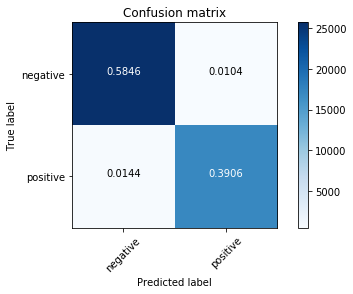

In [122]:
plot_confusion_matrix(cm, ['negative', 'positive'], normalize=True)

[[25725   457]
 [  635 17189]]


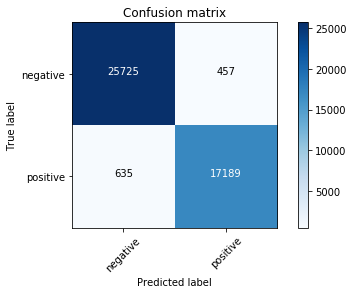

In [121]:
plot_confusion_matrix(cm, ['negative', 'positive'])

In [0]:
ones_idx = np.where(val_y==1)[0]
zeros_idx = np.where(val_y==0)[0]

TP_idx = val_idx[ones_idx[np.where(val_preds[ones_idx]==1)[0]]]
TN_idx = val_idx[zeros_idx[np.where(val_preds[zeros_idx]==0)[0]]]
FP_idx = val_idx[zeros_idx[np.where(val_preds[zeros_idx]==1)[0]]]
FN_idx = val_idx[ones_idx[np.where(val_preds[ones_idx]==0)[0]]]

In [133]:
TP_idx.shape, FN_idx.shape, TN_idx.shape, FP_idx.shape

((17189,), (635,), (25725,), (457,))

## Visualization (grad-CAM)

### True Positive

In [135]:
train_df['id'][TP_idx[10]]

'2a39c7a7f0fed65384a2f48f74d1b592f732ac23'

In [140]:
train_df['id'][np.random.choice(FP_idx, 1)[0]]

'7339894e9bd65b506a182e0b09c8556985c1aeb0'

In [0]:
# load image
def read_rand_img(idxs):
    f = train_df['id'][np.random.choice(idxs, 1)[0]]
    img = Image.open(path+'train/'+f+'.tif')
    return img

# preprocess input images
def preprocess(img):
    transform = T.Compose([
        T.Resize((img_size, img_size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

# compute gradients
def compute_backprop(X, y, model):
    """input: tensors X, y; pytorch model"""
    model.eval()
    scores = model(X)
    correct_scores = scores.squeeze() if y==1 else 1-scores.squeeze()
    loss = correct_scores.sum()
    loss.backward()

# forward propagation for inference
def get_preds(img, model):
    """input img tensor, pytorch model"""
    model.eval()
    logit = model(img)
    prob = torch.sigmoid(logit[:,0]).detach().cpu().numpy()
    return prob

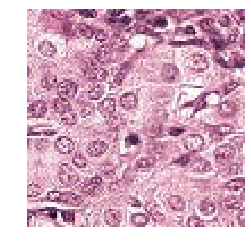

In [203]:
img_pil = read_rand_img(TP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [0]:
net = net.type(dtype)
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 196, 196)

In [205]:
# output the predictions
prob = get_preds(img_tensor, net)
prob

array([0.9999434], dtype=float32)

In [0]:
# feature extractor
def extract_feature(x):
    net.eval()
    return net.backbone2(net.backbone1(x))

class Net_classifier(nn.Module):
    def forward(self, x): return net.classifier(x)

class GradCAM(nn.Module):
    def __init__(self):
        super(GradCAM, self).__init__()
        self.ap = nn.AdaptiveAvgPool2d(1)
    
    def forward(self, feature_maps, feature_grads):
        # features size: (1, k, h, w)
        map_weights = self.ap(feature_grads)   # (1, k, 1, 1)
        maps = torch.sum(map_weights * feature_maps, 1)   # (1, h, w)
        grad_cam = F.relu(maps.squeeze(0))
        return grad_cam

def imresize(img, size):
    im = Image.fromarray(img)
    return np.array(im.resize(size, PIL.Image.BICUBIC))

def returnCAM(feature_maps, class_idx):
    # generate the class activation maps (CAMs) upsample to 256x256
    size_upsample = (img_size, img_size)
    net_classifier = Net_classifier()
    
    feature_maps = feature_maps.type(dtype)
    feature_maps.requires_grad_()

    output_cam = []
    for idx in class_idx:
        compute_backprop(feature_maps, idx, net_classifier)
        gradCAM = GradCAM()
        cam = gradCAM(feature_maps, feature_maps.grad).detach().cpu().numpy()
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        cam = np.uint8(255 * cam)
        output_cam.append(imresize(cam, size_upsample))
        feature_maps.grad.detach_()
        feature_maps.grad.zero_()
    return output_cam

In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [0,1])

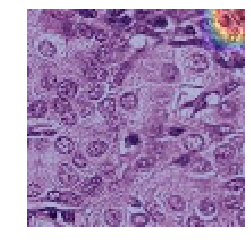

In [207]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

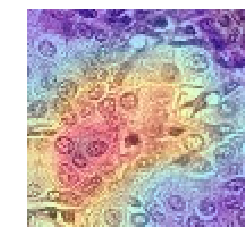

In [208]:
width, height = img_pil.size
heatmap = imresize(CAMs[1], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

### True Negative

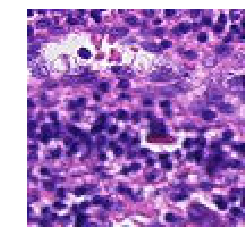

In [180]:
img_pil = read_rand_img(TN_idx)

plt.axis('off')
plt.imshow(img_pil);

In [0]:
net = net.type(dtype)
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 196, 196)

In [182]:
# output the predictions
prob = get_preds(img_tensor, net)
prob

array([0.33058673], dtype=float32)

In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [0,1])

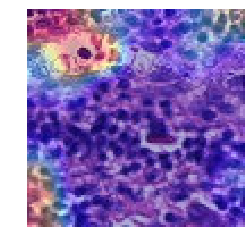

In [195]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

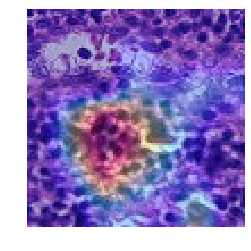

In [196]:
width, height = img_pil.size
heatmap = imresize(CAMs[1], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

### False Positive

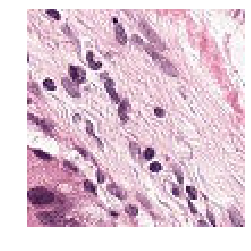

In [197]:
img_pil = read_rand_img(FP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [0]:
net = net.type(dtype)
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 196, 196)

In [199]:
# output the predictions
prob = get_preds(img_tensor, net)
prob

array([0.9479989], dtype=float32)

In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [0,1])

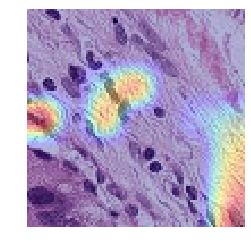

In [201]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

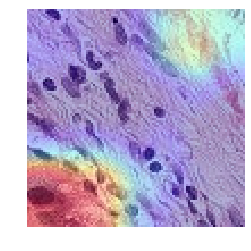

In [202]:
width, height = img_pil.size
heatmap = imresize(CAMs[1], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

### False Negative

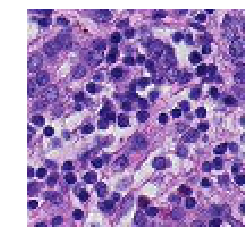

In [209]:
img_pil = read_rand_img(FN_idx)

plt.axis('off')
plt.imshow(img_pil);

In [0]:
net = net.type(dtype)
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 196, 196)

In [211]:
# output the predictions
prob = get_preds(img_tensor, net)
prob

array([0.21955523], dtype=float32)

In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [0,1])

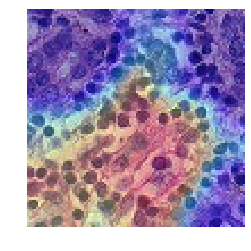

In [213]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

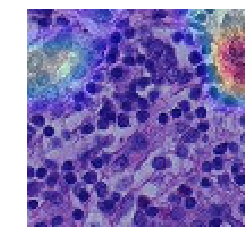

In [214]:
width, height = img_pil.size
heatmap = imresize(CAMs[1], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()